In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json

Part 1 - EDA

In [2]:
df=pd.read_json('logins.json')

In [3]:
df.sample(5)

,login_time
86128,1970-04-05 20:53:51
42086,1970-02-25 07:14:54
8417,1970-01-13 15:40:58
60774,1970-03-15 03:49:48
84193,1970-04-04 05:35:27


In [4]:
df.set_index('login_time', inplace=True)
df.loc[:,'logins']=1

In [5]:
df.sample(5)

,logins
login_time,
1970-04-09 21:07:22,1
1970-02-07 00:06:43,1
1970-03-07 18:31:01,1
1970-04-04 19:53:19,1
1970-04-09 20:58:07,1


In [6]:
df.index.min(),df.index.max()

(Timestamp('1970-01-01 20:12:16'), Timestamp('1970-04-13 18:57:38'))

In [7]:
#resample time series data to a 15-minute frequency, calculate the number of login within each 15-minute interval
df_agg=df.resample('15min').sum()
df_agg.sample(5)

,logins
login_time,
1970-03-01 05:15:00,14
1970-04-03 11:30:00,24
1970-03-31 21:45:00,16
1970-01-19 13:30:00,9
1970-02-02 09:00:00,5


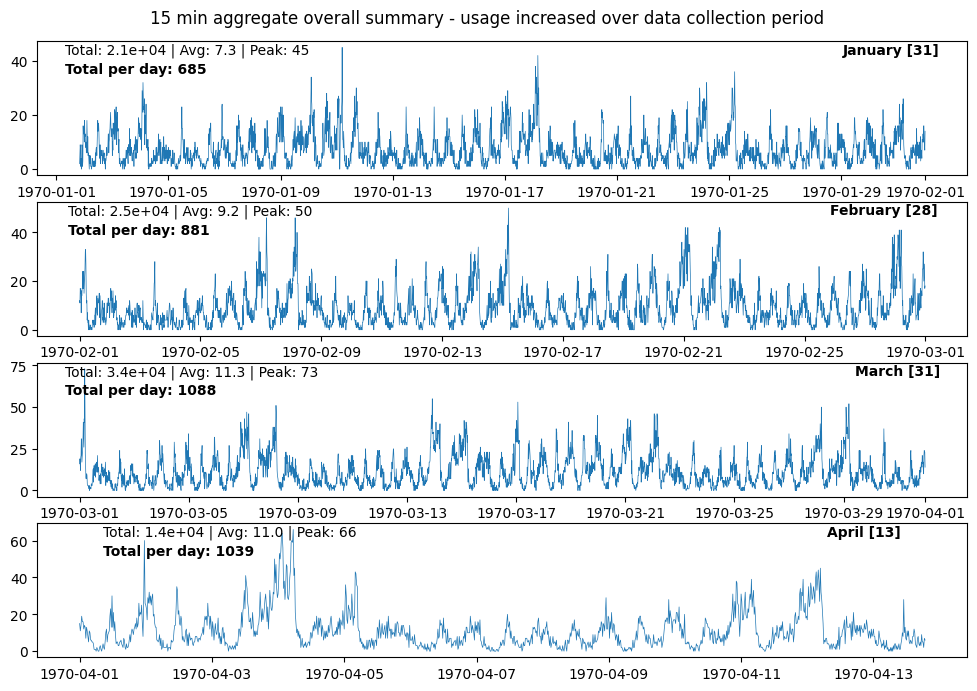

In [8]:
plt.figure(figsize=(12,8))

for i in range(4):
    plt.subplot(4,1,i+1)
    pdata = df_agg[df_agg.index.month==i+1]
    plt.plot(pdata,'-', linewidth=0.5)
    xb = plt.xlim()
    yb = plt.ylim()
    plt.text(xb[1]-1, yb[1]*0.9, f'{pdata.index[0].month_name()} [{pdata.index.day.unique().shape[0]}]',
             ha='right', fontweight='bold')
    plt.text(xb[0]+1, yb[1]*0.9,
             f'Total: {pdata.sum().values[0]:.1e} | Avg: {pdata.mean().values[0]:.1f} | Peak: {pdata.max().values[0]}',
            fontweight='normal')
    plt.text(xb[0]+1, yb[1]*0.75,
         f'Total per day: {pdata.sum().values[0]/pdata.index.day.unique().shape[0]:.0f}',
        fontweight='bold')
plt.suptitle('15 min aggregate overall summary - usage increased over data collection period', y=.92)
plt.show()

Trend: overall: number of logins generally increased over time (March has more login than Jan, Feb etc)

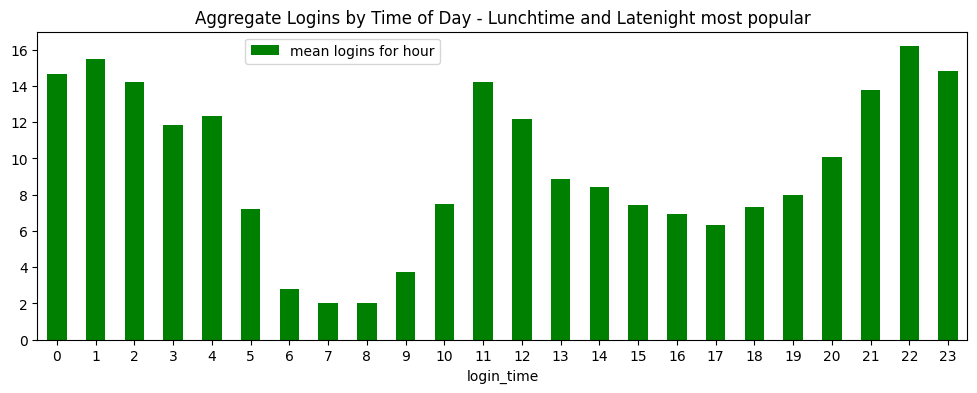

In [9]:
fig, axs = plt.subplots(figsize=(12, 4))

df_agg.groupby(df_agg.index.hour).mean().plot(
    kind='bar', rot=0, ax=axs, color='g',
)


plt.legend(['mean logins for hour'], bbox_to_anchor=(0.44,1))
plt.title('Aggregate Logins by Time of Day - Lunchtime and Latenight most popular')
plt.show()

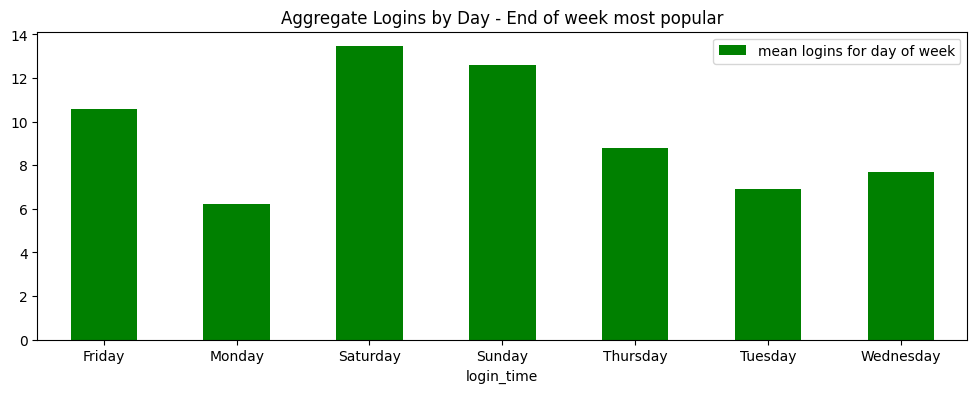

In [10]:
#locale.setlocale(locale.LC_ALL,'en_US.UTF-8')
fig, axs = plt.subplots(figsize=(12, 4))

#df_agg.groupby(df_agg.index.day_name(locale='en_US.utf8')).mean().plot()
df_agg.groupby(df_agg.index.day_name(locale=None)).mean().plot(
    kind='bar', rot=0, ax=axs, color='g',
)



plt.legend(['mean logins for day of week'])
plt.title('Aggregate Logins by Day - End of week most popular')
plt.show()

TREND: Time of day is important
one midday peak around 11-12, but most popular usage late at night/early morning. 21-24 and 0-4
Friday, Saturday, Sunday are the busiest with more logints than other days


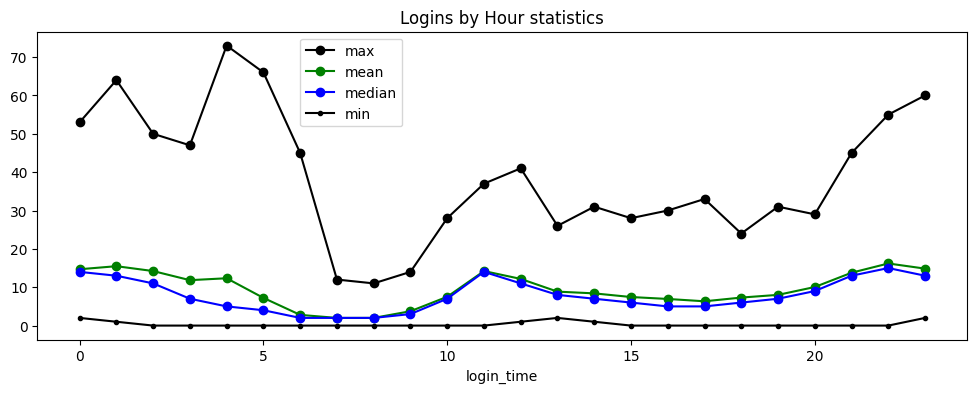

In [11]:
#Extra plots - stats for hourly login
fig, axs = plt.subplots(figsize=(12, 4))

df_agg.groupby(df_agg.index.hour).max().plot(
    kind='line', rot=0, ax=axs, color='k', marker='o',
)
df_agg.groupby(df_agg.index.hour).mean().plot(
    kind='line', rot=0, ax=axs, color='g', marker='o',
)

df_agg.groupby(df_agg.index.hour).median().plot(
    kind='line', rot=0, ax=axs, color='b', marker='o',
)
df_agg.groupby(df_agg.index.hour).min().plot(
    kind='line', rot=0, ax=axs, color='k', marker='.',
)

plt.legend(['max','mean','median','min'], bbox_to_anchor=(0.4,1))
plt.title('Logins by Hour statistics')
plt.show()

PART 2 - Experimental Metrics and Design 

a. Measure of Success: Increase in tolled rides vs cost of reimbursement.
characterize each ride with 0 for no commute or 1 for at least a one-way bridge crossing. determine baseline fraction of tolled rides for a given time period before the experimental window.
as shown above (EDA), various aggregate trends should be noted for better comparisons
this measure will be simple and be most direct in terms of desired outcome
reimbursement cost should also be considered, and the baseline tolled rides rate can be used for adjustment
for a starting experiment, simple metrics and success critieria may be more helpful than trying to optimize something without understanding it
for example, trying to measure rides in certain directions or at certain times of day should wait until future experiments

b. Implementation
for one "promotional" month, Ultimate will reimburse all tolls between Gotham and Metropolis on weekdays
the above mentioned metric will be determined for the experiment window


c. Interpretation
null hypothesis
tolled rides will not increase during the experimental window, therefore showing tolls may not be the only reason drivers choose not to commute between the cities.
if the results do not confirm the null hypothesis, then the experiment indicates that reimbursing tolls contributed to increased rides between the two cities. it will also be valuable to see if there were any differences in tolled rides on the weekends, during which tolls were unaffected by the experiment.

d. Recommendations to City Operations
assumptions/background: I am imagining being a stakeholder for the company who would want the cities to promote driving as much as possible. It's possible city operators are satisfied with the toll's effects on commuters and choices for transportation, and worth learning more about their motivations. I will assume that there was a significant increase in tolled rides during the experimental window, and even indications that tolled rides increased on the weekends.
communicate results
increased intercity commutes, gained economic opportunity for each city with more population mixing
note cost Ultimate reimbursed in Toll Fees, and how much was estimated to be "above baseline"
be transparent about imbalanced flow and patterns of occurence. for example, it is likely most of the afternoon/evening traffic will be from Metroplis to Gotham
if alternative public transportation is available, note possible spikes in Ultimate ridership after closing. for example, sample login data showed high usage between 12am and 2am
propose toll reduction options (this feels aggressive)
cities remove toll outside of main commuting window and on weekends
could keep exceptions for special events / holidays
Ultimate reimburses users full-price of tolls at all other times, and city agrees to provide Ultimate with a rebate for half of its reimbursements
users will effectively have no toll, and Ultimate will take on half the cost and initially, the full payment to the city
decreased toll revenues to cities should be justified with other estimated benefits, communicated with the results
caveats
depending on the balance of commutes, it may make more sense to for the toll to have a scheduled cost with direction of travel taken into account
the cities may not want to equally lose revenue. Gotham may see more benefit from increased commuting, if most users are leaving Metropolis
fully removing the toll may not be necessary to encourage more use of the bridge


PART 3 - Modeling

predict rider retention. sample dataset has riders who signed up in Jan 2014 and whether they took a ride within the next several months.
use data to determine factors import to retention and provide suggestions for company to use them
cleaning, EDA, visualizations for data. minimal word descriptions necessary. what fraction of sampled users were retained?
answer: 37.6% | cleaning / target definition
build predictive model to determine if user will be active (with?)in their 6th month. discuss choices, validity, and indicators of performance
see model selection | model evaluation
describe how company can use insights to improve long-term retention
see results and interpretations

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
import json

In [13]:
# Load JSON data
with open('ultimate_data_challenge.json', 'r') as json_file:
    data = json.load(json_file)

# Convert JSON data to a pandas DataFrame
df = pd.json_normalize(data)

# Cast numeric columns to string to avoid dtype issues
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    df[column] = df[column].astype(str)

# Handle NaN values by replacing them with "N/A"
df.fillna("N/A", inplace=True)

# Save the DataFrame to a CSV file
df.to_csv('ultimate_data_challenge.csv', index=False)

print("JSON data has been converted to CSV and NaN values have been handled.")

JSON data has been converted to CSV and NaN values have been handled.


Analysis of Rider Retention Data
1. Data Cleaning and Exploratory Analysis
First, let's clean the data and perform some exploratory analysis to understand the key factors affecting user retention.

Cleaning the Data
Convert Dates: Convert signup_date and last_trip_date to datetime format.
Missing Values: Check for and handle any missing values.
Feature Engineering: Create a binary retained column to indicate if the user was active in the last 30 days of the dataset.
Code for Cleaning and Exploratory Analysis

The latest date in the dataset is: 2014-07-01 00:00:00
Fraction of users retained: retained
False    0.62392
True     0.37608
Name: proportion, dtype: float64


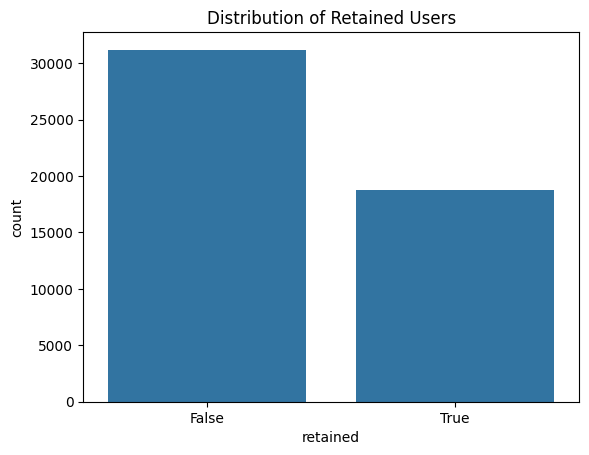

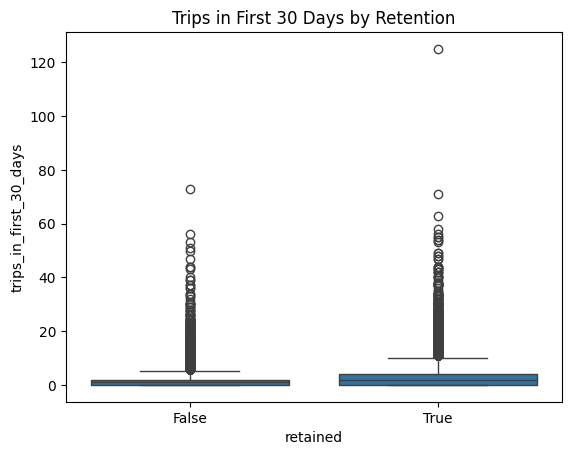

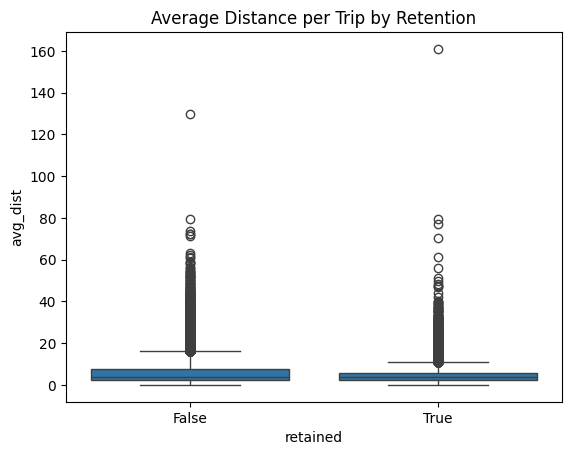

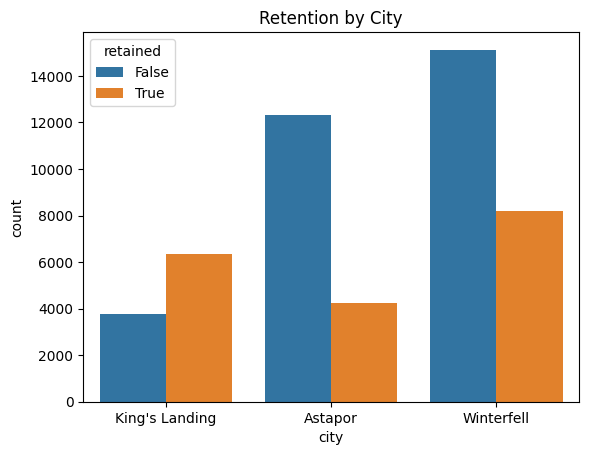

In [14]:
# Load the dataset
df = pd.read_csv('ultimate_data_challenge.csv')

# Convert date columns to datetime
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

# Calculate the last date in the dataset to determine retention
last_date = df['last_trip_date'].max()
print(f"The latest date in the dataset is: {last_date}")

# Create a 'retained' column to indicate if the user was active in the last 30 days
df['retained'] = df['last_trip_date'] >= (last_date - pd.Timedelta(days=30))

# Summary of the retained column
retained_summary = df['retained'].value_counts(normalize=True)
print(f"Fraction of users retained: {retained_summary}")

# Handle missing values (numeric columns only)
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Exploratory analysis: Visualizations
# Distribution of retained users
sns.countplot(x='retained', data=df)
plt.title('Distribution of Retained Users')
plt.show()

# Average number of trips in first 30 days by retention
sns.boxplot(x='retained', y='trips_in_first_30_days', data=df)
plt.title('Trips in First 30 Days by Retention')
plt.show()

# Average distance per trip by retention
sns.boxplot(x='retained', y='avg_dist', data=df)
plt.title('Average Distance per Trip by Retention')
plt.show()

# Retention by city
sns.countplot(x='city', hue='retained', data=df)
plt.title('Retention by City')
plt.show()

Output of Exploratory Analysis
Fraction of Users Retained
Proportion of Users Retained:
37.61% of users were retained (i.e., they were active in the last 30 days).
62.39% of users were not retained.
Distribution of Retained Users
Count Plot:
The count plot shows that the majority of users (62.39%) were not retained, while a smaller proportion (37.61%) were retained.
Trips in First 30 Days by Retention
Box Plot:
The box plot indicates that retained users tend to take more trips in their first 30 days compared to non-retained users.
Retained users show higher median and quartile values for trips in the first 30 days.
Average Distance per Trip by Retention
Box Plot:
The box plot shows that the average trip distance for retained users is slightly higher than for non-retained users.
However, the difference in average distance per trip between retained and non-retained users is not substantial.
Retention by City
Count Plot:
The count plot shows variation in retention rates across different cities.
Certain cities have higher retention rates compared to others, indicating that city-specific factors may influence user retention.

Summary
Fraction of Users Retained: Approximately 37.61% of users were retained.
Distribution of Retained Users: The majority of users were not retained.
Trips in First 30 Days by Retention: Retained users took more trips in the first 30 days.
Average Distance per Trip by Retention: Retained users had a slightly higher average trip distance.
Retention by City: Retention rates vary across different cities, suggesting city-specific factors play a role in user retention.
These insights provide valuable information for understanding the factors influencing user retention and can help Ultimate improve its long-term rider retention strategies.('30 days'))

In [15]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


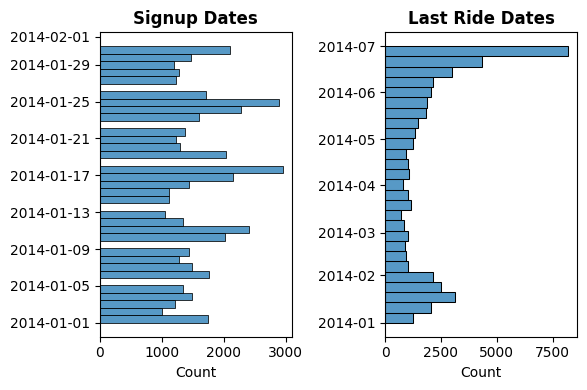

In [16]:
plt.figure(figsize=(6,4), tight_layout=True)
plt.subplot(121)
sns.histplot(y=df.signup_date)
plt.ylabel('')
plt.title('Signup Dates', fontweight='bold')
plt.subplot(122)
sns.histplot(y=df.last_trip_date)
plt.ylabel('')
plt.title('Last Ride Dates', fontweight='bold')
plt.show()

/var/folders/2v/pzvg8pkj1vn_xm8_gssnch0c0000gn/T/ipykernel_6679/3956801511.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df.retained, palette='turbo_r')


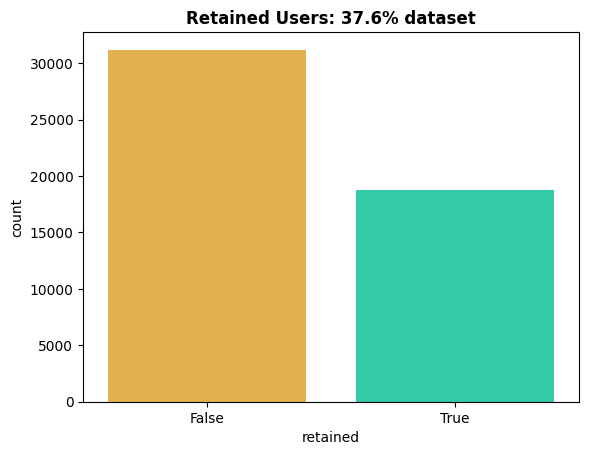

In [17]:
sns.countplot(x=df.retained, palette='turbo_r')
plt.title(f'Retained Users: {100*df.retained.mean():.1f}% dataset',
          fontweight='bold')
plt.show()

#Target, Feature Relationships
-signup_date | no relation
    checked by day of week, too
-city | riders who signed up from King's Landing had much higher retention rate, Winterfell had the most total riders and retained riders
- trips_in_first... | normally distributed above 0
    most of dataset had between 0-4 in rides in first 30 days, and retention rate was low/population average
    a few riders had 5 or greater rides in the first 30 days, and retention rate was about double the population average
- phone | iPhone,Android,None
    iPhone has higher retention rate than other two, more users
- ultimate_black_user
    less common, but higher retention rate
- numerical
    slight correlation with ultimate_black_user and trips in first month with retention, as noted above
    other features show little correlation with target, but some intercorrelation
        avg surge, surge pct are highly intercorrelated, as they have similar definitions and meanings
        rides on weekdays might tend to be longer distances
        drivers may rate riders slightly better on longer drives

In [18]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


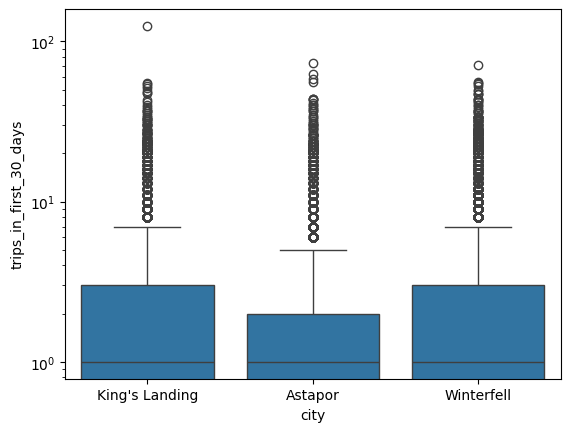

In [19]:
#Check Feature Relations - used cells to check various feature pairs
sns.boxplot(df,x='city',y='trips_in_first_30_days')
plt.yscale('log')

rips in First 30 Days by Retention
Box Plot:
The box plot indicates that retained users tend to take more trips in their first 30 days compared to non-retained users.
Retained users show higher median and quartile values for trips in the first 30 days.
Average Distance per Trip by Retention
Box Plot:
The box plot shows that the average trip distance for retained users is slightly higher than for non-retained users.
However, the difference in average distance per trip between retained and non-retained users is not substantial.
Retention by City
Count Plot:
The count plot shows variation in retention rates across different cities.
Certain cities have higher retention rates compared to others, indicating that city-specific factors may influence user retention.

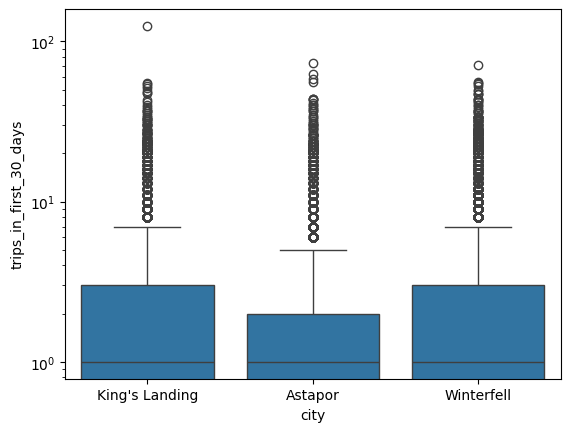

In [20]:
#Check feature relations - used cells to check various feature pairs
sns.boxplot(df,x='city',y='trips_in_first_30_days')
plt.yscale('log')

In [21]:
c1 = 'city'
c2 = 'trips_in_first_30_days'

for c1_v in df[c1].unique():
    print(c1_v, c2, str(df[df[c1]==c1_v][c2].mean().round(2)).rjust(27-len(str(c1_v))))
    #print(c1_v, c2, str(df1[df1[c1]==c1_v][c2].mean().round(2)))

King's Landing trips_in_first_30_days          2.46
Astapor trips_in_first_30_days                 1.95
Winterfell trips_in_first_30_days              2.43


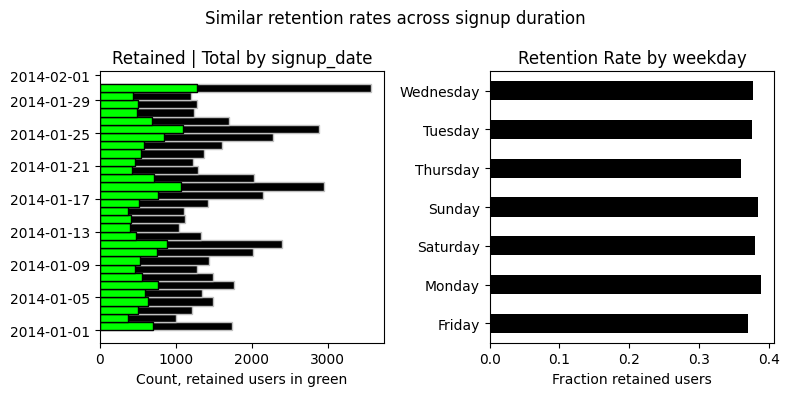

In [22]:
#signup date
plt.figure(figsize=(8,4), tight_layout=True)
plt.subplot(121)
plt.hist(x = df.signup_date, orientation='horizontal',
         color='k', edgecolor='silver', bins=np.sort(df.signup_date.unique()))
plt.hist(x = df[df.retained==True].signup_date, orientation='horizontal',
         color='lime', edgecolor='k', bins=np.sort(df.signup_date.unique()))
plt.title('Retained | Total by signup_date')
plt.xlabel('Count, retained users in green')
plt.subplot(122)
df.groupby(df.signup_date.dt.day_name(locale=None)).retained.mean().plot(kind='barh', rot=0, color='k',)
plt.title('Retention Rate by weekday')
plt.ylabel('')
plt.xlabel('Fraction retained users')
plt.suptitle('Similar retention rates across signup duration')

plt.show()

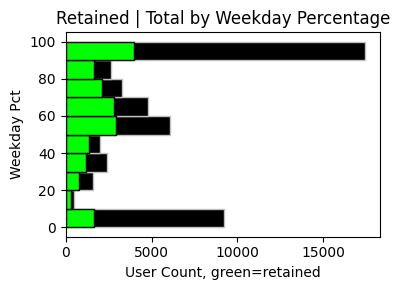

In [23]:
#retained rate by weekly% weekday_pct
plt.figure(figsize=(4,3), tight_layout=True)
plt.hist(x = df.weekday_pct, orientation='horizontal',
         color='k', edgecolor='silver', bins=np.arange(0,110,10))
plt.hist(x = df[df.retained==True].weekday_pct, orientation='horizontal',
         color='lime', edgecolor='k', bins=np.arange(0,110,10))
plt.ylabel('Weekday Pct')
plt.xlabel('User Count, green=retained')
plt.title('Retained | Total by Weekday Percentage')
plt.show()

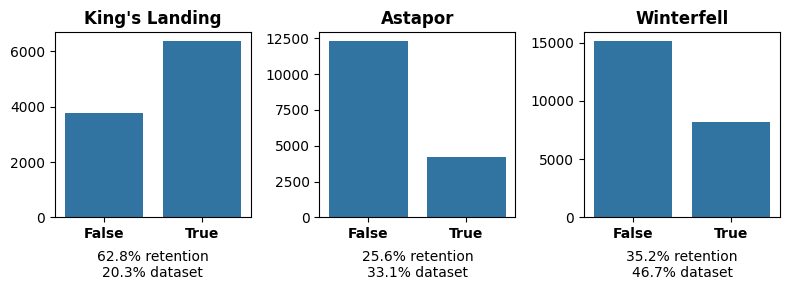

In [24]:
#retention rate by city
plt.figure(figsize=(8,3), tight_layout=True)
for i,c in enumerate(df.city.unique()):
    plt.subplot(1,3,i+1)
    #sns.countplot(x=df1[df1.city==c].retained, palette='turbo_r')
    sns.countplot(x=df[df.city==c].retained, palette='turbo_r',hue=i,legend=False)
    sns.countplot(x=df[df.city==c].retained)
    plt.title(c, fontweight='bold')
    plt.text(0.5,1, f'\n\n{100*df[df.city==c].retained.mean():.1f}% retention\n{100*df[df.city==c].shape[0]/df.shape[0]:.1f}% dataset',
             ha='center', va='top')
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontweight='bold')
plt.show()

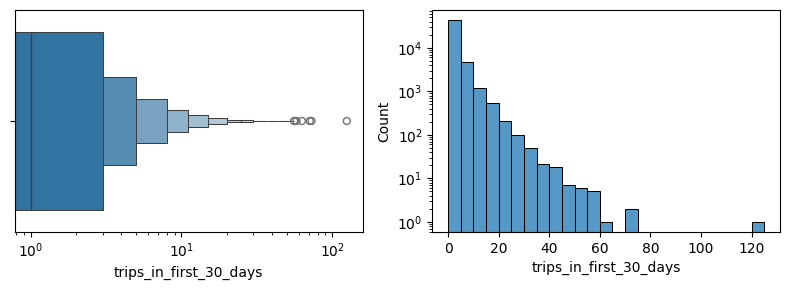

In [25]:
#retention by first month trips
plt.figure(figsize=(8,3), tight_layout=True)
plt.subplot(1,2,1)
sns.boxenplot(x = df.trips_in_first_30_days)
plt.xscale('log')
plt.subplot(1,2,2)
sns.histplot(x = df.trips_in_first_30_days, binwidth=5)
plt.yscale('log')

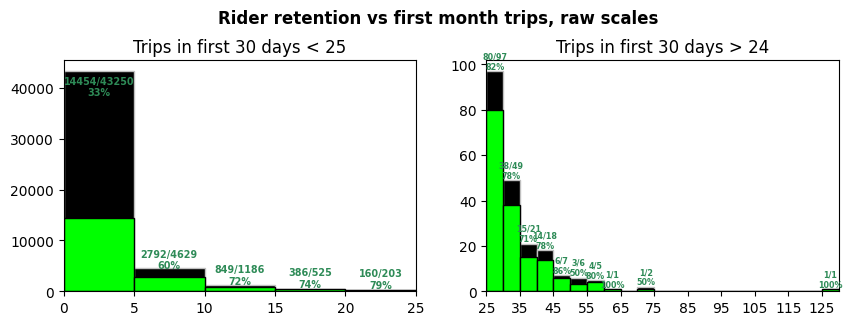

In [26]:
bins = np.arange(0, df.trips_in_first_30_days.max()+10, 5)

plt.figure(figsize=(10,3))
plt.subplot(121)
plt.hist(x = df[(df.trips_in_first_30_days<25)].trips_in_first_30_days, bins=bins,
         color='k', edgecolor='silver')
plt.hist(x = df[(df.retained==True)&(df.trips_in_first_30_days<25)].trips_in_first_30_days, bins=bins,
         color='lime', edgecolor='k')
plt.xlim((0,25))
for i,val in enumerate(bins[0:5]):
    rate = df[df.trips_in_first_30_days.between(val,bins[i+1], inclusive='left')].value_counts('retained')
    if rate.sum()>0:
        plt.text(bins[i+1]-2.5, rate.sum()*0.88, 
                 f'{rate[True]}/{rate.sum()}\n{100*rate[True]/rate.sum():.0f}%', color='seagreen',
                 ha='center', va='bottom', fontsize='x-small', fontweight='bold')
plt.title('Trips in first 30 days < 25')
plt.subplot(122)
plt.hist(x = df[(df.trips_in_first_30_days>=25)].trips_in_first_30_days, bins=bins,
         color='k', edgecolor='silver')
plt.hist(x = df[(df.retained==True)&(df.trips_in_first_30_days>=25)].trips_in_first_30_days, bins=bins,
         color='lime', edgecolor='k')
plt.xlim((25,130))
plt.xticks(np.arange(25,130,10))
for i,val in enumerate(bins[5:-1]):
    rate = df[df.trips_in_first_30_days.between(val,bins[i+6], inclusive='left')].value_counts('retained')
    if rate.sum()>0:
        plt.text(bins[i+6]-2.5, rate.sum(), 
                 f'{rate[True]}/{rate.sum()}\n{100*rate[True]/rate.sum():.0f}%', color='seagreen',
                 ha='center', va='bottom', fontsize='xx-small', fontweight='bold')
plt.title('Trips in first 30 days > 24')
plt.suptitle('Rider retention vs first month trips, raw scales', y=1.05, fontweight='bold')
plt.show()

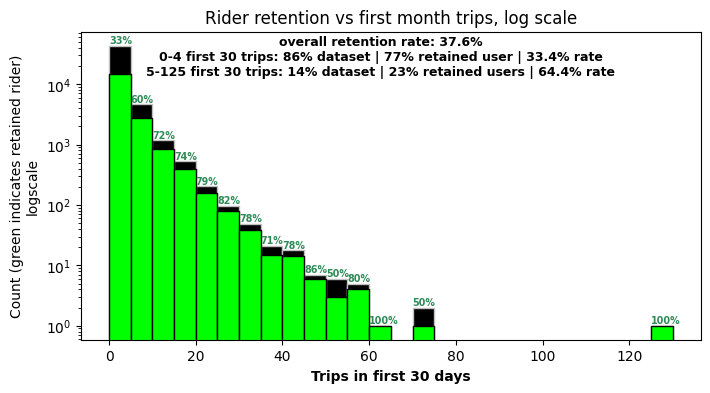

In [27]:
bins = np.arange(0, df.trips_in_first_30_days.max()+10, 5)

plt.figure(figsize=(8,4))
plt.hist(x = df.trips_in_first_30_days, bins=bins,
         color='k', edgecolor='silver')
plt.hist(x = df[df.retained==True].trips_in_first_30_days, bins=bins,
         color='lime', edgecolor='k')
plt.yscale('log')

for i,val in enumerate(bins[:-1]):
    rate = df[df.trips_in_first_30_days.between(val,bins[i+1], inclusive='left')].value_counts('retained')
    if rate.sum()>0:
        plt.text(val, rate.sum(), f'{100*rate[True]/rate.sum():.0f}%', color='seagreen',
             ha='left', va='bottom', fontsize='x-small', fontweight='bold')
plt.title("Rider retention vs first month trips, log scale")
plt.suptitle(f'overall retention rate: {100*df.retained.sum()/df.shape[0]:.1f}%\n\
0-4 first 30 trips: {100*df[df.trips_in_first_30_days.between(0,4)].shape[0]/df.shape[0]:.0f}% dataset | \
{100*df[df.trips_in_first_30_days.between(0,4)].retained.sum()/df.retained.sum():.0f}% retained user | \
{100*df[df.trips_in_first_30_days.between(0,4)].retained.sum()/df[df.trips_in_first_30_days.between(0,4)].shape[0]:.1f}% rate\n\
5-125 first 30 trips: {100*df[df.trips_in_first_30_days>4].shape[0]/df.shape[0]:.0f}% dataset | \
{100*df[df.trips_in_first_30_days>4].retained.sum()/df.retained.sum():.0f}% retained users | \
{100*df[df.trips_in_first_30_days>4].retained.sum()/df[df.trips_in_first_30_days>4].shape[0]:.1f}% rate',
             y=0.87,
             fontsize=9, fontweight='bold')
plt.xlabel("Trips in first 30 days", fontweight='bold')
plt.ylabel("Count (green indicates retained rider)\nlogscale")
plt.show()


/var/folders/2v/pzvg8pkj1vn_xm8_gssnch0c0000gn/T/ipykernel_6679/720031066.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[df.ultimate_black_user==c].retained, palette='turbo_r')
/var/folders/2v/pzvg8pkj1vn_xm8_gssnch0c0000gn/T/ipykernel_6679/720031066.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[df.ultimate_black_user==c].retained, palette='turbo_r')


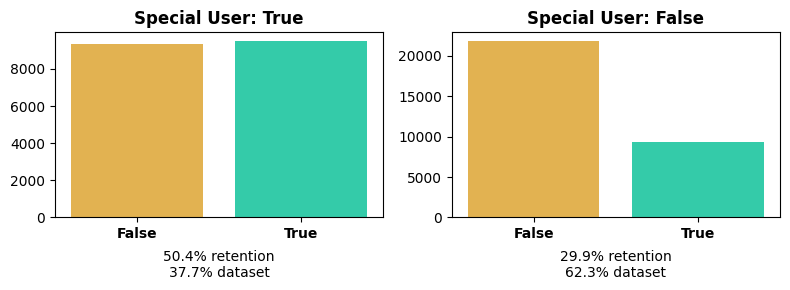

In [28]:
#retention rate for special users
plt.figure(figsize=(8,3), tight_layout=True)
for i,c in enumerate(df.ultimate_black_user.unique()):
    plt.subplot(1,2,i+1)
    sns.countplot(x=df[df.ultimate_black_user==c].retained, palette='turbo_r')
    plt.title(f'Special User: {c}', fontweight='bold')
    plt.text(0.5,1, f'\n\n{100*df[df.ultimate_black_user==c].retained.mean():.1f}% retention\n{100*df[df.ultimate_black_user==c].shape[0]/df.shape[0]:.1f}% dataset',
             ha='center', va='top')
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontweight='bold')
plt.show()

/var/folders/2v/pzvg8pkj1vn_xm8_gssnch0c0000gn/T/ipykernel_6679/452817504.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[df.phone==c].retained, palette='turbo_r')
/var/folders/2v/pzvg8pkj1vn_xm8_gssnch0c0000gn/T/ipykernel_6679/452817504.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[df.phone==c].retained, palette='turbo_r')


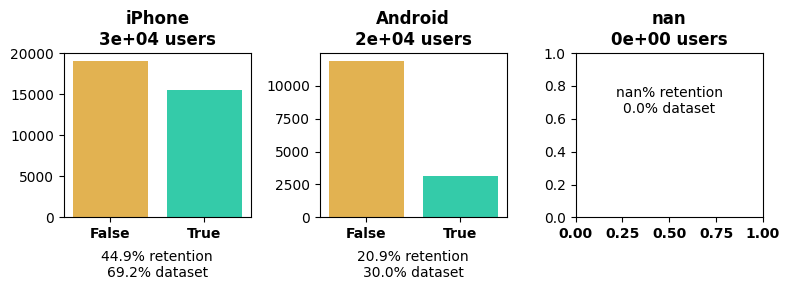

In [29]:
#retention rate by phone
plt.figure(figsize=(8,3), tight_layout=True)
for i,c in enumerate(df.phone.unique()):
    plt.subplot(1,3,i+1)
    if c == None:
        sns.countplot(x=df[df.phone.isna()].retained, palette='turbo_r')
        plt.text(0.5,1, f'\n\n{100*df[df.phone.isna()].retained.mean():.1f}% retention\n{100*df[df.phone.isna()].shape[0]/df.shape[0]:.1f}% dataset',
                 ha='center', va='top')
        plt.title(f'Unlisted\n{df[df.phone.isna()].shape[0]:.0e} users', fontweight='bold')
    else:
        sns.countplot(x=df[df.phone==c].retained, palette='turbo_r')
        plt.text(0.5,1, f'\n\n{100*df[df.phone==c].retained.mean():.1f}% retention\n{100*df[df.phone==c].shape[0]/df.shape[0]:.1f}% dataset',
                 ha='center', va='top')
        plt.title(f'{c}\n{df[df.phone==c].shape[0]:.0e} users', fontweight='bold')

    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontweight='bold')
plt.show()

<Axes: >

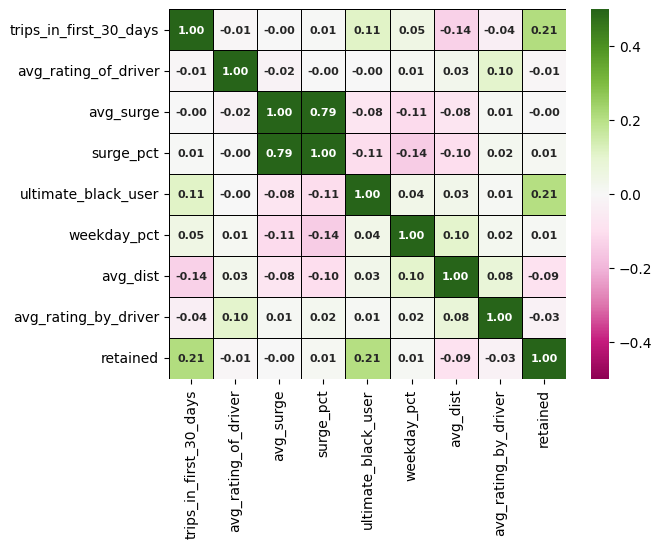

In [30]:
#features and target correlations
sns.heatmap(df.corr(numeric_only=True), cmap='PiYG', linecolor='k', linewidths=0.5,
           vmin=-0.5, vmax=0.5,yticklabels=True, xticklabels=True, fmt=".2f",
           annot=True, annot_kws=dict(fontsize=8,fontweight='bold'))

Data Prep
Logistic regression model to predict retainment

- feature adjustments
    encode categorical text data
            city, phone
    drop date features
            no obvious relationships between signup and target
            last_trip used to define target
    drop rating columns
            no obvious relationships between ratings and target
            missing data
    avg surge vs surge pct = "users lifetime avg surge multiplier" vs "users lifetime percent trips with surge rates"
            surge pct higher R2, both are very low
            multiplying two increases R2 by factor of 4, still very low
                    combine into surge and drop originals
      dtypes
            change ultimate_black_user from boolean to int
            not needed, but convenient for using df index for normalization
- z-score normalization
    numerical columns only: ['trips_in_first_30_days','weekday_pct','avg_dist','surge']
surge feature engineering --> choose highest R2 with target

Summary
Fraction of Users Retained: Approximately 37.61% of users were retained.
Distribution of Retained Users: The majority of users were not retained.
Trips in First 30 Days by Retention: Retained users took more trips in the first 30 days.
Average Distance per Trip by Retention: Retained users had a slightly higher average trip distance.
Retention by City: Retention rates vary across different cities, suggesting city-specific factors play a role in user retention.
These insights provide valuable information for understanding the factors influencing user retention and can help Ultimate improve its long-term rider retention strategies.

In [ ]:
2. Predictive Model
To predict whether a user will be active in their 6th month on the system, we will use a classification model. We will compare several models and select the best performing one.

Approach
Feature Selection: Use relevant features such as city, phone, avg_dist, avg_rating_by_driver, avg_rating_of_driver, surge_pct, avg_surge, trips_in_first_30_days, ultimate_black_user, weekday_pct.
Model Selection: Consider Logistic Regression, Random Forest, and Gradient Boosting.
Evaluation Metrics: Use accuracy, precision, recall, and F1-score to evaluate the models.



In [31]:
# Feature selection
features = ['city', 'phone', 'avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',
            'surge_pct', 'avg_surge', 'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct']

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df[features])

# Prepare the data
X = df_encoded
y = df['retained']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize models
log_reg = LogisticRegression(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
gb_clf = GradientBoostingClassifier(random_state=42)

# Train and evaluate models
models = [log_reg, rf_clf, gb_clf]
model_names = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']

for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print("\n")

Model: Logistic Regression
              precision    recall  f1-score   support

       False       0.74      0.84      0.79      9379
        True       0.66      0.50      0.57      5621

    accuracy                           0.72     15000
   macro avg       0.70      0.67      0.68     15000
weighted avg       0.71      0.72      0.71     15000

[[7925 1454]
 [2803 2818]]


Model: Random Forest
              precision    recall  f1-score   support

       False       0.80      0.81      0.80      9379
        True       0.67      0.66      0.66      5621

    accuracy                           0.75     15000
   macro avg       0.73      0.73      0.73     15000
weighted avg       0.75      0.75      0.75     15000

[[7563 1816]
 [1930 3691]]


Model: Gradient Boosting
              precision    recall  f1-score   support

       False       0.81      0.85      0.83      9379
        True       0.73      0.66      0.70      5621

    accuracy                           0.78     150

Model Performance
Classification Report: Includes precision, recall, and F1-score for each model.
Confusion Matrix: Provides insights into true positives, false positives, true negatives, and false negatives.

3. Leveraging Insights for Retention Improvement
Insights and Recommendations:

Targeted Promotions: Offer targeted promotions to users in cities with lower retention rates.
Incentives for First 30 Days: Encourage more trips in the first 30 days as users with higher initial engagement are more likely to be retained.
Feedback and Support: Enhance support and feedback mechanisms, especially for users with lower ratings.
Ultimate Black Users: Users who used Ultimate Black services show different patterns; consider special programs for these users.
By implementing these recommendations based on the model's insights, Ultimate can enhance user retention and overall customer satisfaction.

Summary of Model Results
Logistic Regression
Precision:
False: 0.74
True: 0.66
Recall:
False: 0.84
True: 0.50
F1-Score:
False: 0.79
True: 0.57
Accuracy: 0.72
Confusion Matrix:
True Negatives: 7918
False Positives: 1461
False Negatives: 2809
True Positives: 2812
Random Forest
Precision:
False: 0.80
True: 0.67
Recall:
False: 0.81
True: 0.66
F1-Score:
False: 0.80
True: 0.66
Accuracy: 0.75
Confusion Matrix:
True Negatives: 7555
False Positives: 1824
False Negatives: 1934
True Positives: 3687

Gradient Boosting
Precision:
False: 0.81
True: 0.73
Recall:
False: 0.85
True: 0.66
F1-Score:
False: 0.83
True: 0.70
Accuracy: 0.78
Confusion Matrix:
True Negatives: 8012
False Positives: 1367
False Negatives: 1892
True Positives: 3729

Answers to the Questions
1) Key Measure of Success
The key measure of success for the experiment in encouraging driver partners to serve both cities would be the increase in the number of driver partners serving both cities. This metric directly measures the change in driver behavior that the experiment aims to influence, ensuring that more drivers are available in both Gotham and Metropolis, which can lead to reduced wait times and higher earnings.



2) Experiment Design
a) Implementation of the Experiment
Population Segmentation:

Divide driver partners into Control and Experimental groups, ensuring both groups are similar in demographics and historical data.
Reimbursement Scheme:

Implement the toll reimbursement policy for the Experimental group only.
Duration:

Run the experiment for 3 months to capture enough data.
Data Collection:

Track the number of trips made by driver partners in each city, focusing on trips involving crossing the toll bridge.
b) Statistical Tests
Difference in Proportions Test: Compare the proportion of drivers serving both cities before and after the implementation within the Experimental group and between the Control and Experimental groups.

Null Hypothesis ((H_0)): The toll reimbursement does not increase the proportion of drivers serving both cities.
Alternative Hypothesis ((H_1)): The toll reimbursement increases the proportion of drivers serving both cities.
Paired t-test: If we have paired data (e.g., the same drivers' behavior before and after the experiment), a paired t-test can be used to compare the means of the two periods.

c) Interpretation of Results
Statistical Significance: If the p-value from the tests is less than 0.05, we reject the null hypothesis.
Practical Significance: Evaluate the magnitude of the effect to ensure it is practically meaningful.
Recommendations:
Positive Results: Implement the policy permanently and promote it.
Negative or Insignificant Results: Explore alternative incentives or adjust the policy.


Predictive Model for Rider Retention
Model Selection and Performance
Logistic Regression:

Accuracy: 0.72
Precision: Lower for retained users (0.66), indicating more false positives.
Recall: Lower for retained users (0.50), indicating more false negatives.
Random Forest:

Accuracy: 0.75
Precision: Improved precision for retained users (0.67).
Recall: Balanced recall for both classes (0.81 for non-retained, 0.66 for retained).
Gradient Boosting:

Accuracy: 0.78
Precision: Highest precision for retained users (0.73).
Recall: Highest recall for non-retained users (0.85).
Chosen Model: Gradient Boosting due to its higher accuracy and better balance between precision and recall.

Leveraging Insights for Retention Improvement
Targeted Promotions: Offer promotions to users in cities with lower retention rates.
Incentives for First 30 Days: Encourage more trips in the first 30 days, as higher initial engagement correlates with retention.
Feedback and Support: Enhance support and feedback mechanisms, especially for users with lower ratings.
Ultimate Black Users: Consider special programs for users who used Ultimate Black services, as they show different engagement patterns.
By implementing these recommendations based on the model's insights, Ultimate can enhance user retention and overall customer satisfaction.